## Team 1 - Project - Air Quality Analysis (United States)

##### Loading modules

In [2]:
import pandas as pd
#google bigquery is used to query EPA Data
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import numpy as np

# import plotly
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as fig_fact
plotly.tools.set_config_file(world_readable=True, sharing='public')

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
from pandas.plotting import autocorrelation_plot as acp

#### Data Source : US EPA data set hosted on Google Bigquery

In [3]:
#authentication object from google bigquery
client = bigquery.Client.from_service_account_json(
        'My First Project-3e4c7a361fa1.json')

In [4]:
#SQL query on bigquery

# Querying annual AQI for all gases
query_job = client.query("""
       
    SELECT
         *
        FROM
        `bigquery-public-data.epa_historical_air_quality.air_quality_annual_summary`
        
        where date_of_last_change > DATE("2015-01-01")
        
        LIMIT 10
      """)
results = query_job.result()  # Waits for job to complete.
df_pois_gases = results.to_dataframe()


In [5]:
#Querying carbon monoxide(CO) and nitrous oxide(NO)'s AQI
query_job = client.query( """
    SELECT
        co_daily.state_name,
        avg(co_daily.aqi) as co_avg_aqi,
        avg(no_daily.aqi) as no_avg_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.co_daily_summary` AS co_daily
    INNER JOIN `bigquery-public-data.epa_historical_air_quality.no2_daily_summary` AS no_daily
        ON co_daily.state_name = no_daily.state_name
    WHERE
      co_daily.poc = 1
      AND no_daily.poc = 1
      AND EXTRACT(YEAR FROM co_daily.date_local) = 2016
      AND EXTRACT(YEAR FROM no_daily.date_local) = 2016
    GROUP BY co_daily.state_name
        """)

results = query_job.result()  # Waits for job to complete.
df_pois_gases = results.to_dataframe()

In [6]:
#Querying ozone's AQI
query_job = client.query("""
    SELECT
        o3_daily.state_name,
        avg(o3_daily.aqi) as o3_avg_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.o3_daily_summary` AS o3_daily
    WHERE
      o3_daily.poc = 1
      AND EXTRACT(YEAR FROM o3_daily.date_local) = 2016
    GROUP BY o3_daily.state_name
        """)
results = query_job.result()  # Waits for job to complete.
df_states_gas_o3 = results.to_dataframe()

In [7]:
#Query Sulphur dioxide's AQI
query_job = client.query( """
    SELECT
        so2_daily.state_name,
        avg(so2_daily.aqi) as so2_avg_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.so2_daily_summary` AS so2_daily
    WHERE
      so2_daily.poc = 1
      AND EXTRACT(YEAR FROM so2_daily.date_local) = 2016
    GROUP BY so2_daily.state_name
        """)
results = query_job.result()  # Waits for job to complete.
df_states_gas_so2 = results.to_dataframe()

In [8]:
#Concant above gases to pois_gases dataframe
df_pois_gases['o3_avg_aqi'] = df_pois_gases['state_name'].map(df_states_gas_o3.set_index('state_name')['o3_avg_aqi'])
df_pois_gases['so2_avg_aqi'] = df_pois_gases['state_name'].map(df_states_gas_so2.set_index('state_name')['so2_avg_aqi'])

In [9]:
states = {'AL': 'Alabama',
'AK': 'Alaska',
'AZ':'Arizona',
'AR':'Arkansas',
'CA':'California',
'CO':'Colorado',
'CT':'Connecticut',
'DE':'Delaware',
'FL':'Florida',
'GA':'Georgia',
'HI':'Hawaii',
'ID':'Idaho',
'IL':'Illinois',
'IN':'Indiana',
'IA':'Iowa',
'KS':'Kansas',
'KY':'Kentucky',
'LA':'Louisiana',
'ME':'Maine',
'MD':'Maryland',
'MA':'Massachusetts',
'MI':'Michigan',
'MN':'Minnesota',
'MS':'Mississippi',
'MO':'Missouri',
'MT':'Montana',
'NE':'Nebraska',
'NV':'Nevada',
'NH':'New Hampshire',
'NJ':'New Jersey',
'NM':'New Mexico',
'NY':'New York',
'NC':'North Carolina',
'ND':'North Dakota',
'OH':'Ohio',
'OK':'Oklahoma',
'OR':'Oregon',
'PA':'Pennsylvania',
'RI':'Rhode Island',
'SC':'South Carolina',
'SD':'South Dakota',
'TN':'Tennessee',
'TX':'Texas',
'UT':'Utah',
'VT':'Vermont',
'VA':'Virginia',
'WA':'Washington',
'WV':'West Virginia',
'WI':'Wisconsin',
'WY':'Wyoming'}

In [10]:
df_states = pd.DataFrame.from_dict(states,orient='index').reset_index()
df_states.columns = ['code', 'code_name']
df_pois_gases['state_code'] = df_pois_gases['state_name'].map(df_states.set_index('code_name')['code'])

#### Distribution of AQI of greenhouse gases across United States (using choropleth plotly)

In [11]:
#scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],[0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(236,223,219)'],[0.4, 'rgb(220,187,187)'],[0.6, 'rgb(199,154,154)'],[0.8, 'rgb(203,95,95)'],[1.0, 'rgb(229,39,39)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_pois_gases['state_code'],
        z = df_pois_gases['o3_avg_aqi'].astype(float),
        locationmode = 'USA-states',
        text =  df_pois_gases['state_name'].astype(str) + '<br> Average AQI' + '<br>' + df_pois_gases['no_avg_aqi'].astype(str) + '<br>' + 'CO: ' + df_pois_gases['co_avg_aqi'].astype(str) + '<br>' + 'SO2: ' + df_pois_gases['so2_avg_aqi'].astype(str),
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "AQI of O3")
        ) ]

layout = dict(
        title = 'The average air quality index of dangerous gases (CO, SO2, NO2) in different states of US<br>',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )




    
fig = dict( data=data, layout=layout )

py.iplot( fig, filename='d3-cloropleth-map' )

### Carbon Monoxide Analysis

#### AQI of CO in different states

In [12]:
query_job = client.query( """
    SELECT
        state_name,
        avg(aqi) as avg_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.co_daily_summary`
    WHERE
      poc = 1
    GROUP BY state_name
    ORDER BY avg_aqi ASC
        """)

results = query_job.result()  # Waits for job to complete.
df_CO_Avg = results.to_dataframe()

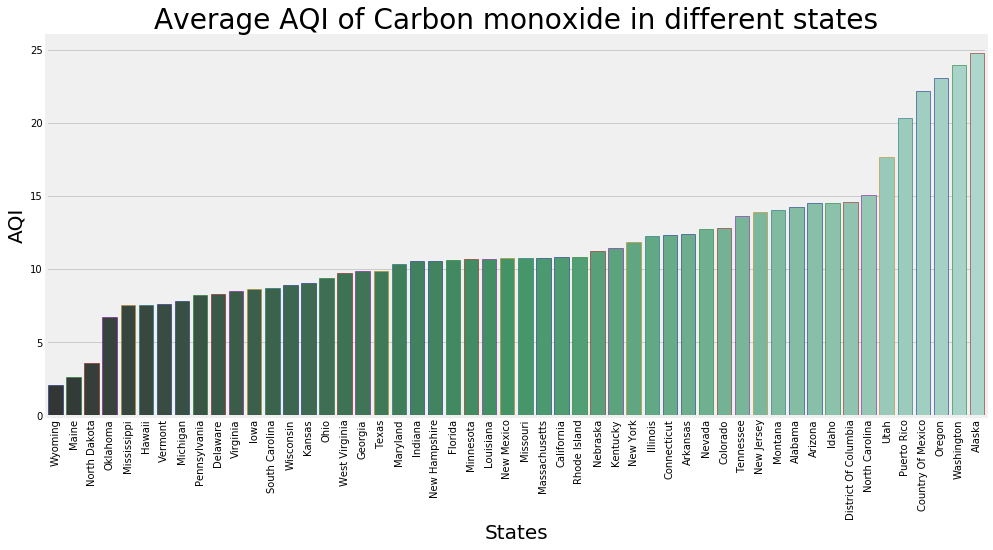

In [13]:
plt.subplots(figsize=(15,7))
sns.barplot(x='state_name',y='avg_aqi',data=df_CO_Avg,palette='BuGn_d',edgecolor=sns.color_palette('dark',7))
plt.ylabel('AQI', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('States', fontsize=20)
plt.title('Average AQI of Carbon monoxide in different states', fontsize=28)
plt.show()

### Max AQI of CO in each year

In [14]:
query_job = client.query("""
    SELECT
        EXTRACT(YEAR FROM date_local) as day_of_year,
        MAX(aqi) as max_aqi
    FROM
      `bigquery-public-data.epa_historical_air_quality.co_daily_summary`
    WHERE
      poc = 1
    GROUP BY day_of_year
    ORDER BY day_of_year ASC
        """)

results = query_job.result()  # Waits for job to complete.
df_co_max = results.to_dataframe()

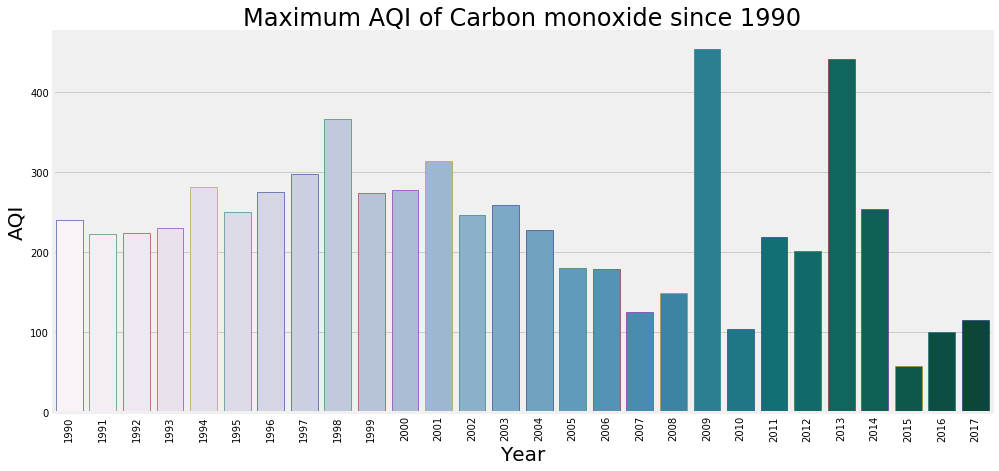

In [15]:
colors = ["windows blue", "orange red", "grey", "amber"]  
myPalette = sns.xkcd_palette(colors)
plt.subplots(figsize=(15,7))
sns.barplot(x='day_of_year',y='max_aqi',data=df_co_max,palette='PuBuGn',edgecolor=sns.color_palette('dark',7))
plt.ylabel('AQI', fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Year', fontsize=20)
plt.title('Maximum AQI of Carbon monoxide since 1990', fontsize=24)
plt.show()

#### Combining temperature and pressure to correlate with ozone and PM2.5

In [16]:
query_job = client.query("""
    SELECT
       EXTRACT(DAYOFYEAR FROM T.date_local) AS Day, AVG(T.arithmetic_mean) AS Temperature
    FROM
      `bigquery-public-data.epa_historical_air_quality.temperature_daily_summary` as T
    WHERE
      T.state_name = 'Washington'
      AND EXTRACT(YEAR FROM T.date_local) = 2016
    GROUP BY Day
    ORDER BY Day
""")
results = query_job.result()  # Waits for job to complete.
df_temp = results.to_dataframe()

query_job = client.query("""
    SELECT
       EXTRACT(DAYOFYEAR FROM rh.date_local) AS Day, AVG(rh.arithmetic_mean) AS Humidity
    FROM
      `bigquery-public-data.epa_historical_air_quality.rh_and_dp_daily_summary` as rh
    WHERE
      rh.state_name = 'Washington'
      AND rh.parameter_name = 'Relative Humidity'
      AND EXTRACT(YEAR FROM rh.date_local) = 2016
    GROUP BY Day
    ORDER BY Day
""")

results = query_job.result()  # Waits for job to complete.
df_pres = results.to_dataframe()

query_job = client.query("""
    SELECT
       EXTRACT(DAYOFYEAR FROM o3.date_local) AS Day, AVG(o3.aqi) AS o3_AQI
    FROM
      `bigquery-public-data.epa_historical_air_quality.o3_daily_summary` as o3
    WHERE
      o3.state_name = 'Washington'
      AND EXTRACT(YEAR FROM o3.date_local) = 2016
    GROUP BY Day
    ORDER BY Day
""")

results = query_job.result()  # Waits for job to complete.
df_o3daily = results.to_dataframe()

query_job = client.query("""
    SELECT
       EXTRACT(DAYOFYEAR FROM pm25.date_local) AS Day, AVG(pm25.aqi) AS pm25_AQI
    FROM
      `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary` as pm25
    WHERE
      pm25.state_name = 'Washington'
      AND pm25.sample_duration = '24 HOUR'
      AND EXTRACT(YEAR FROM pm25.date_local) = 2016
    GROUP BY Day
    ORDER BY Day
""")
results = query_job.result()  # Waits for job to complete.
df_pm25daily = results.to_dataframe()



In [17]:
#df_pres.head()
df_daily = pd.concat([df_temp, df_pres, df_o3daily, df_pm25daily], axis=1, join='inner')
df_daily.tail(10)

,Day,Temperature,Day,Humidity,Day,o3_AQI,Day,pm25_AQI
335,336,40.374008,336,92.452381,336,28.666667,354,13.00
336,337,41.156543,337,92.760417,337,33.250000,355,47.00
337,338,42.553922,338,89.177083,338,36.500000,357,48.00
338,339,39.110294,339,82.854167,339,33.750000,358,42.00
339,340,32.669118,340,92.864583,340,24.666667,359,40.00
340,341,31.513001,341,81.333333,341,28.500000,360,59.00
341,342,27.985294,342,70.541667,342,30.750000,361,49.75
342,343,27.713725,343,55.764583,343,31.500000,364,37.00
343,344,28.350490,344,94.177083,344,31.000000,365,37.00
344,345,31.262255,345,93.072916,345,33.750000,366,52.00


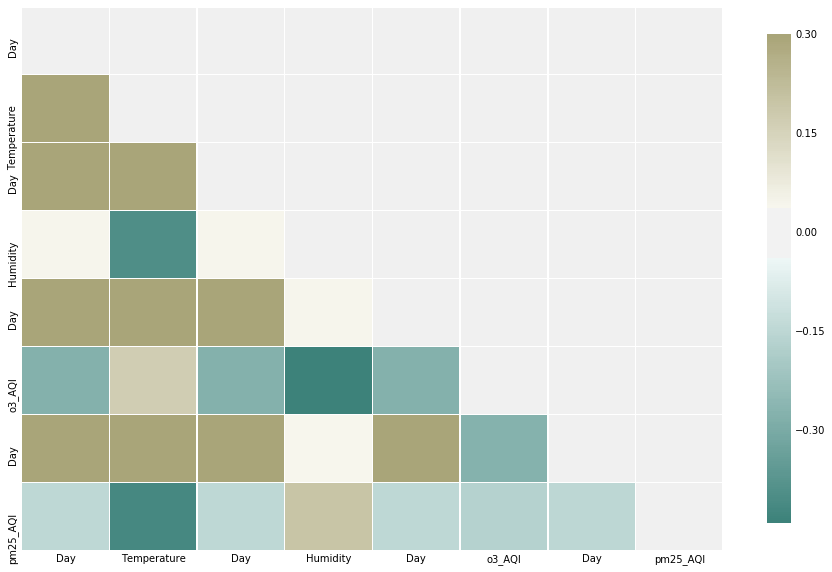

In [18]:
corr = df_daily.corr()
mask = np.zeros_like(corr, dtype=np.bool) #mask is for zero values to be masked
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(14, 10))
cmap = sns.diverging_palette(180, 80, sep=22, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=False, linewidths=.5, cbar_kws={"shrink": .9});

In [19]:
All=pd.read_csv('All.csv')
All.head()

,Unnamed: 0,year,state_code,parameter_name,state_name,parameter_code,arithmetic_mean,ninety_five_percentile,ten_percentile
0,0,1980,01,Nitrogen dioxide (NO2),Alabama,42602,43.840207,102.500000,14.000000
1,1,1980,02,Nitrogen dioxide (NO2),Alaska,42602,6.548793,20.666667,0.683333
2,2,1980,04,Nitrogen dioxide (NO2),Arizona,42602,37.631056,90.000000,13.333333
3,3,1980,05,Nitrogen dioxide (NO2),Arkansas,42602,11.170405,32.500000,0.000000
4,4,1980,06,Nitrogen dioxide (NO2),California,42602,40.178992,84.464286,17.857143


In [20]:
ninety_five=All.pivot_table(values='ninety_five_percentile', index='year', columns = 'parameter_name', aggfunc='mean')
ten=All.pivot_table(values='ten_percentile', index='year', columns = 'parameter_name', aggfunc='mean')
arith_mean=All.pivot_table(values='arithmetic_mean', index='year', columns = 'parameter_name', aggfunc='mean')

In [21]:
ninety_five.index.names=['year']
ninety_five.columns.names=['']
ninety_five.head()

,Average Ambient Pressure,Average Ambient Temperature,Carbon monoxide,Nitrogen dioxide (NO2),Outdoor Temperature,Ozone,Sulfur dioxide
year,,,,,,,
1980,NaN,NaN,4.473324,63.424296,60.250000,0.081761,40.147226
1981,NaN,NaN,4.320641,56.464545,73.904762,0.073771,38.913079
1982,NaN,NaN,4.040848,53.723911,75.842857,0.073012,37.411012
1983,NaN,NaN,4.069038,53.368632,71.747619,0.079772,34.829016
1984,NaN,NaN,3.910003,52.952815,78.514286,0.075206,35.965004


In [22]:
temp= pd.read_csv('global_temp.csv', index_col=0)
ninety_five['temp'] = temp['temp']

In [23]:
ninety_five.head()

,Average Ambient Pressure,Average Ambient Temperature,Carbon monoxide,Nitrogen dioxide (NO2),Outdoor Temperature,Ozone,Sulfur dioxide,temp
year,,,,,,,,
1980,NaN,NaN,4.473324,63.424296,60.250000,0.081761,40.147226,0.27
1981,NaN,NaN,4.320641,56.464545,73.904762,0.073771,38.913079,0.33
1982,NaN,NaN,4.040848,53.723911,75.842857,0.073012,37.411012,0.13
1983,NaN,NaN,4.069038,53.368632,71.747619,0.079772,34.829016,0.31
1984,NaN,NaN,3.910003,52.952815,78.514286,0.075206,35.965004,0.16


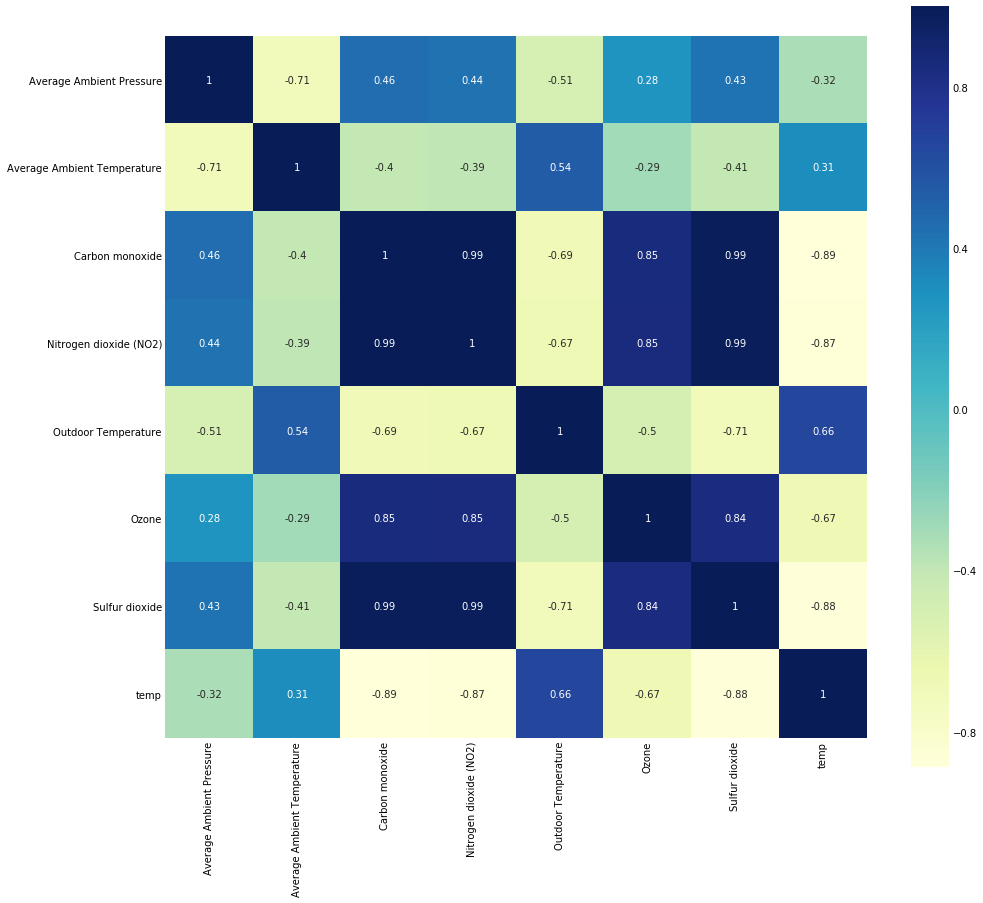

In [24]:
corrmat = ninety_five.corr(method='spearman')
f, ax = plt.subplots(figsize=(14, 14))
# Draw the heatmap using seaborn
import seaborn as sns
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.show()

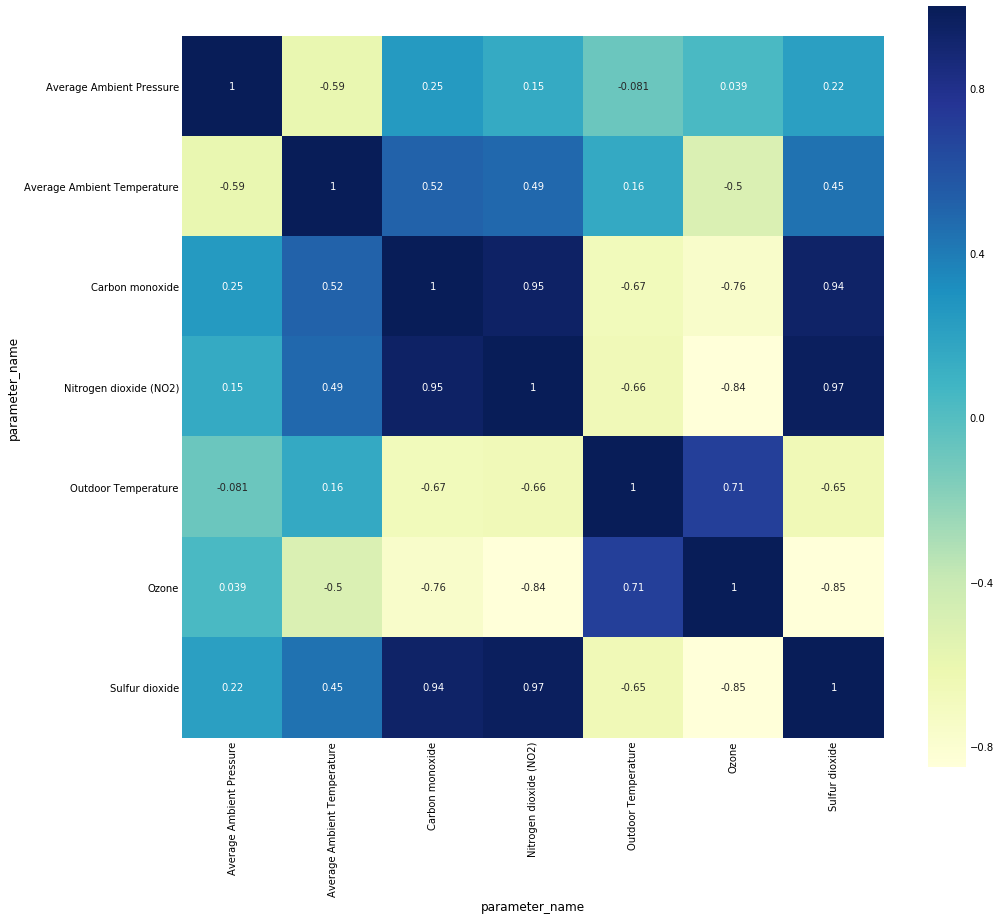

In [25]:
corrmat = ten.corr(method='spearman')
f, ax = plt.subplots(figsize=(14, 14))
# Draw the heatmap using seaborn
import seaborn as sns
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.show()

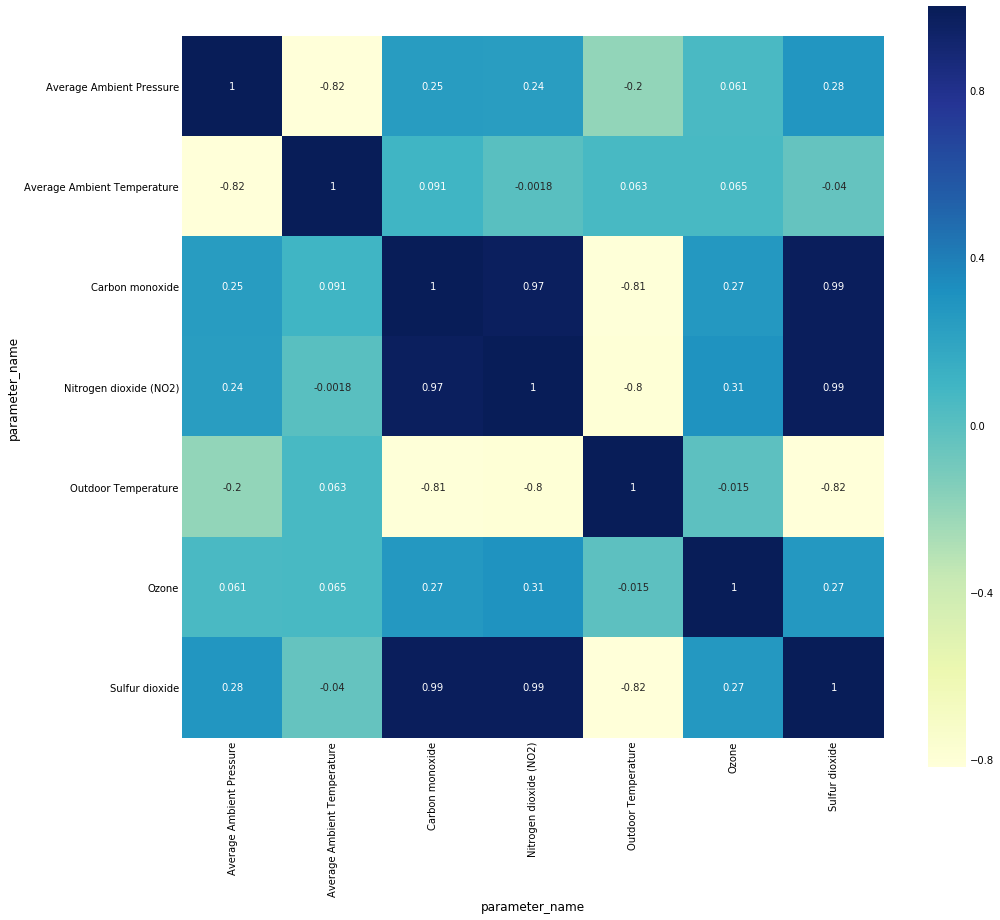

In [26]:
corrmat = arith_mean.corr(method='spearman')
f, ax = plt.subplots(figsize=(14, 14))
# Draw the heatmap using seaborn
import seaborn as sns
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.show()

In [27]:
from numpy import corrcoef, sum, log, arange
from numpy.random import rand
from pylab import pcolor, show, colorbar, xticks, yticks
R= corrcoef(ninety_five)

In [28]:
test5 = pd.DataFrame(R.reshape(-1, len(R)))
test5=test5.dropna(subset=[29,29]).dropna(axis=1)

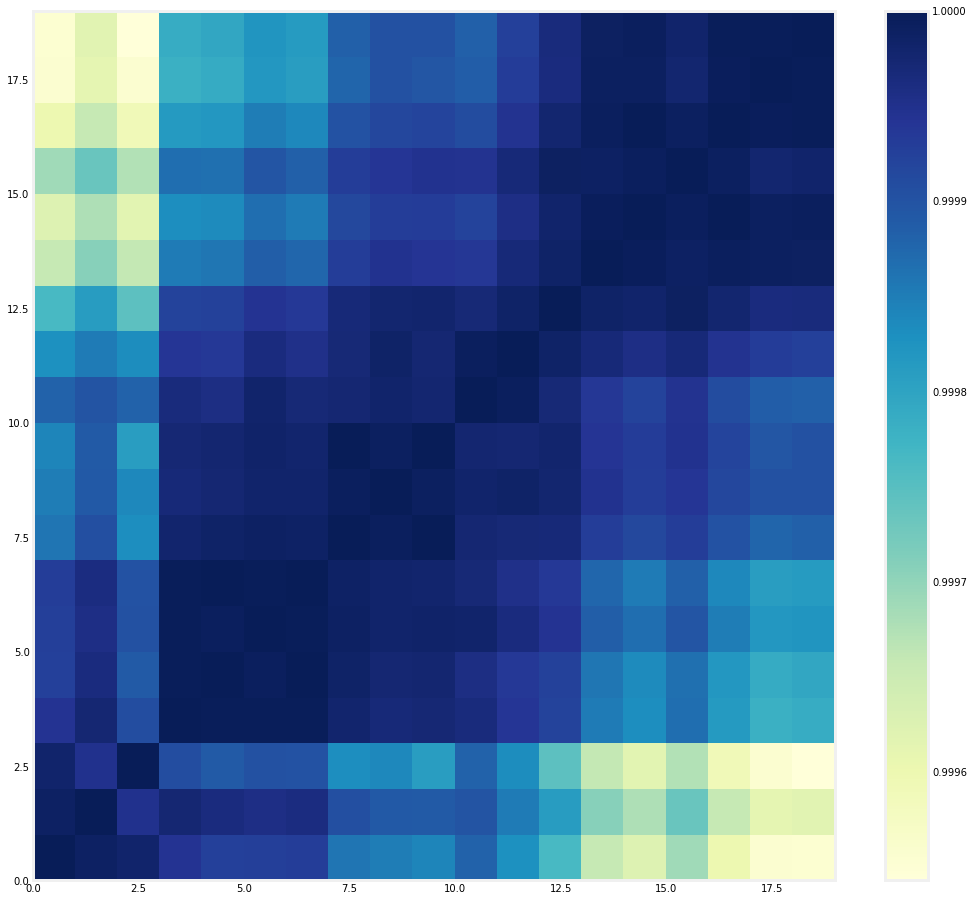

In [29]:
plt.figure(figsize=(16,16))
plt.pcolor(test5,cmap='YlGnBu')
plt.colorbar()
plt.show()

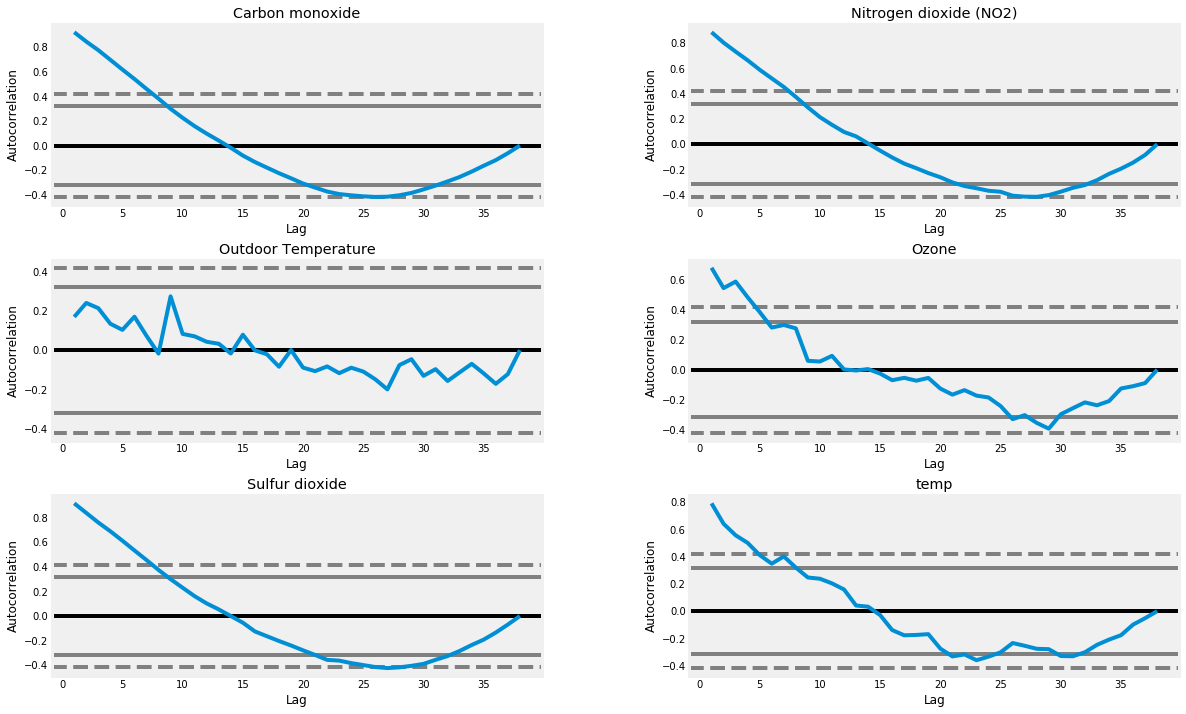

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
k=2
for i in range(3):
    for j in range(2):
        axes[i,j]=acp(ninety_five[ninety_five.columns[k]],axes[i,j])
        axes[i,j].set_title(list(ninety_five.head(0))[k])
        k=k+1
        plt.show   

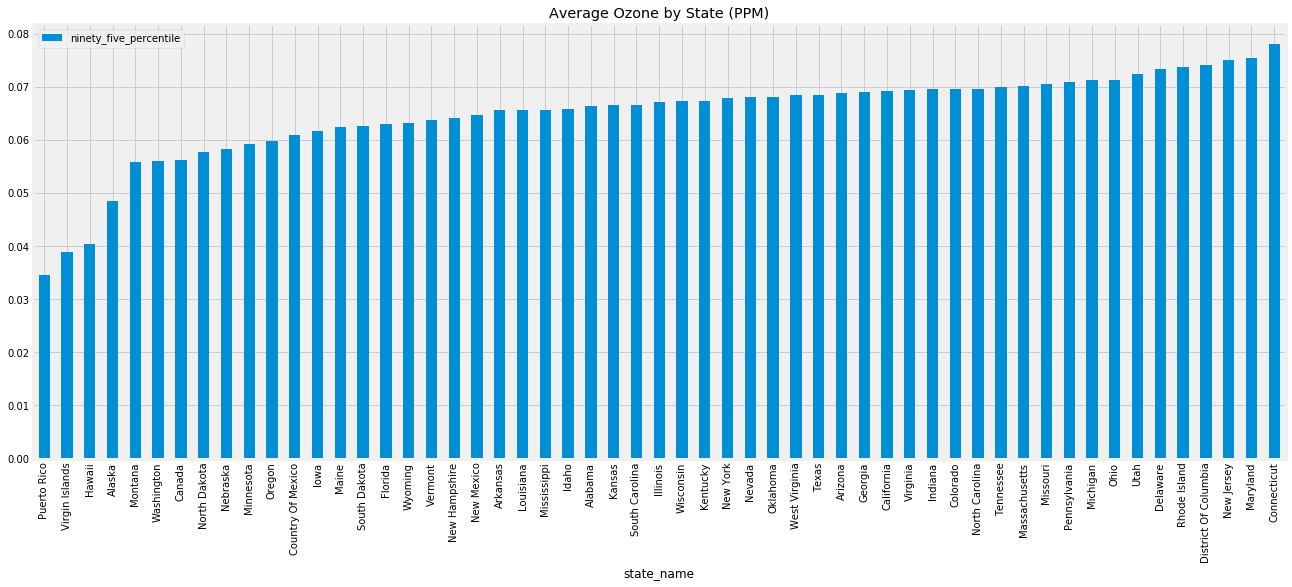

In [31]:
test2=All.loc[All['parameter_name']=='Ozone'].loc[All['year']>2000].sort_values(by=['ninety_five_percentile'])
test3 = pd.pivot_table(test2, index='state_name', values='ninety_five_percentile', aggfunc='mean').sort_values(by=['ninety_five_percentile'])
test3=test3.reset_index()
test3.plot(kind='bar', figsize=(20,8), x='state_name', title='Average Ozone by State (PPM)')

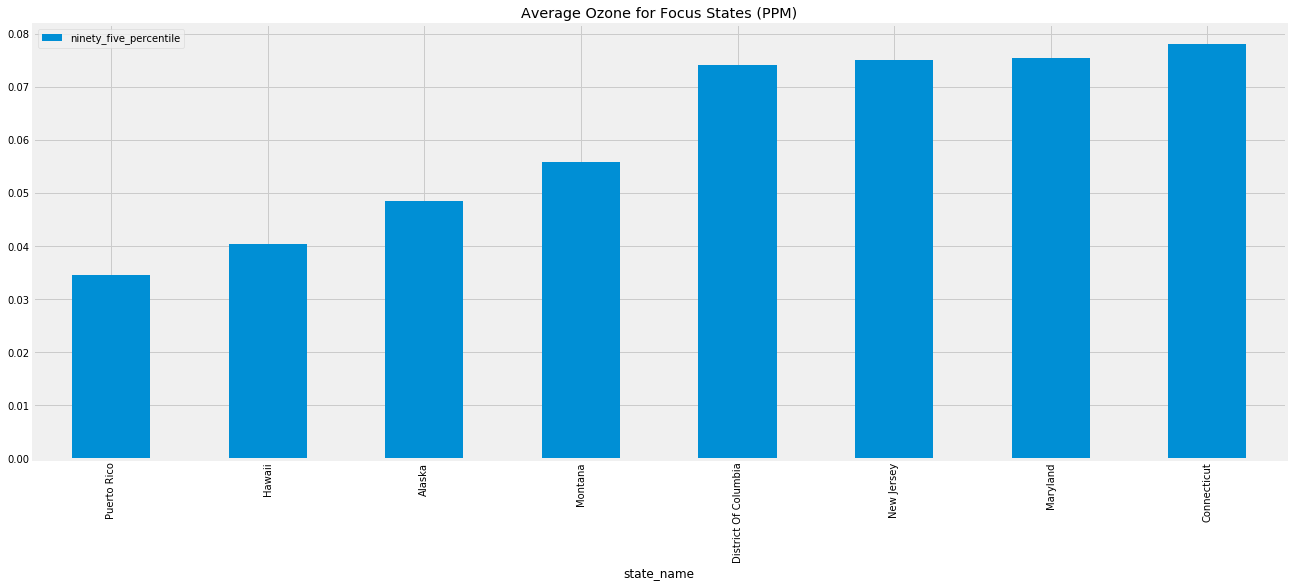

In [32]:
test2=All.loc[All['parameter_name']=='Ozone'].loc[All['year']>2000].sort_values(by=['ninety_five_percentile'])
test3 = pd.pivot_table(test2, index='state_name', values='ninety_five_percentile', aggfunc='mean').sort_values(by=['ninety_five_percentile'])
test3=test3.reset_index()
focus_states = ['Puerto Rico','Hawaii','Alaska','District Of Columbia','New Jersey','Maryland','Connecticut','Montana']
test3=test3[test3['state_name'].isin(focus_states)]
test3.plot(kind='bar', figsize=(20,8), x='state_name',title='Average Ozone for Focus States (PPM)')

In [33]:
df=All[All['state_name'].isin(focus_states)]

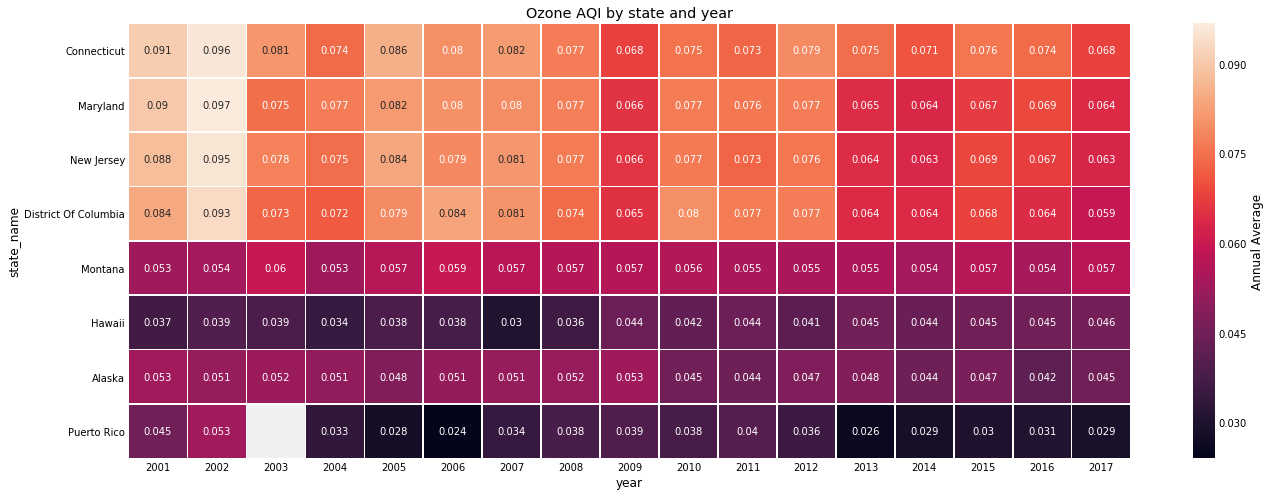

In [34]:
test2=df.loc[df['parameter_name']=='Ozone'].loc[df['year']>2000].sort_values(by=['ninety_five_percentile'])
test2 = pd.pivot_table(test2, index='state_name', values='ninety_five_percentile', columns='year')
test2 = test2.sort_values(by=[2017],ascending = False)
f, ax = plt.subplots(figsize=(20,8))
ax.set_title('Ozone AQI by state and year')
sns.heatmap(test2, annot=True, linewidths=.5, ax=ax,cbar_kws={'label': 'Annual Average'})

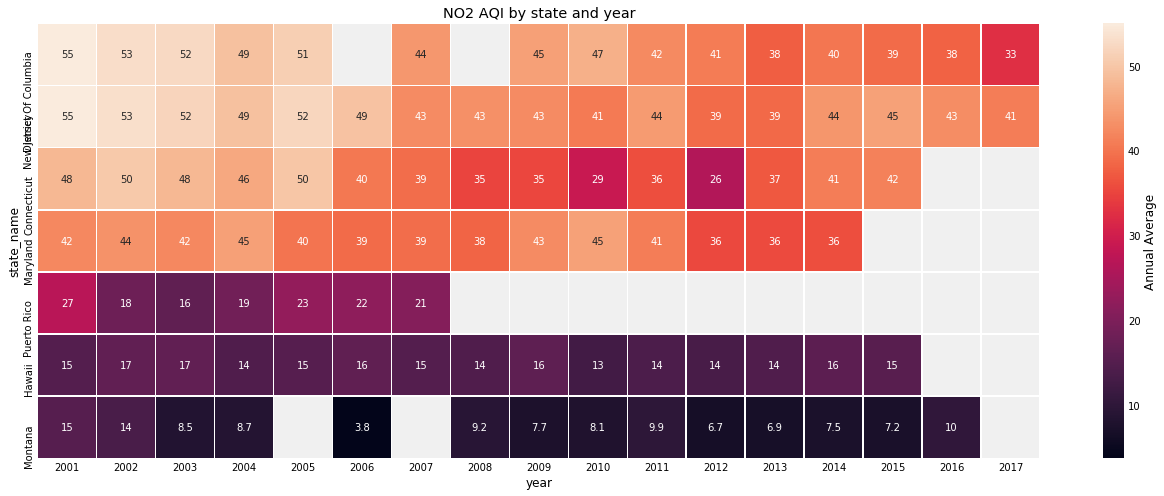

In [35]:
test2=df.loc[df['parameter_name']=='Nitrogen dioxide (NO2)'].loc[df['year']>2000]
test2 = pd.pivot_table(test2, index='state_name', values='ninety_five_percentile', columns='year')
test2 = test2.sort_values(by=[2004],ascending = False)
f, ax = plt.subplots(figsize=(20,8))
ax.set_title('NO2 AQI by state and year')
sns.heatmap(test2, annot=True, linewidths=.5, ax=ax,cbar_kws={'label': 'Annual Average'})

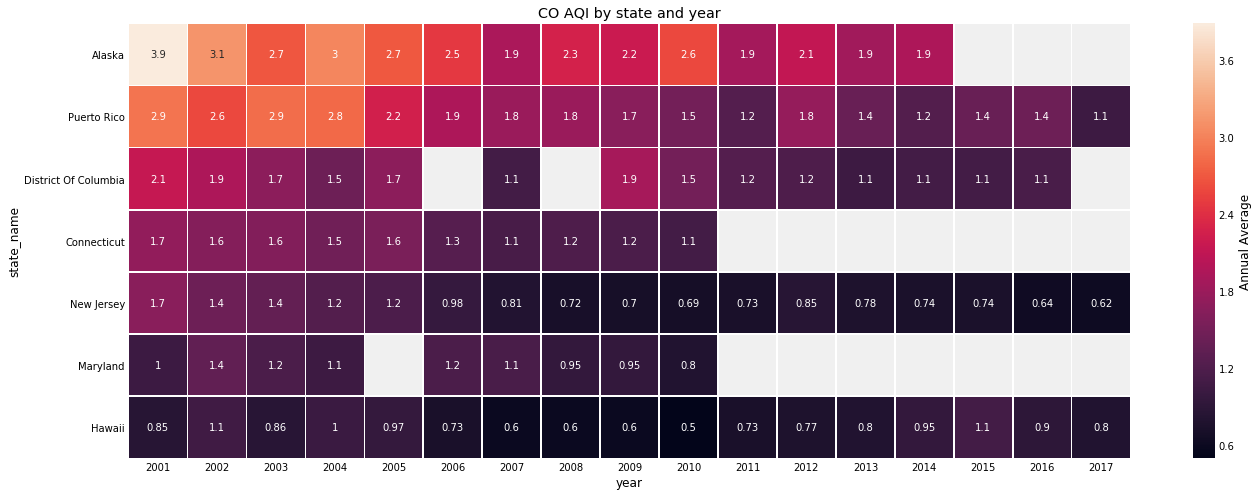

In [36]:
test2=df.loc[df['parameter_name']=='Carbon monoxide'].loc[df['year']>2000]
test2 = pd.pivot_table(test2, index='state_name', values='ninety_five_percentile', columns='year')
test2 = test2.sort_values(by=[2001],ascending = False)
f, ax = plt.subplots(figsize=(20,8))
ax.set_title('CO AQI by state and year')
sns.heatmap(test2, annot=True, linewidths=.5, ax=ax,cbar_kws={'label': 'Annual Average'})

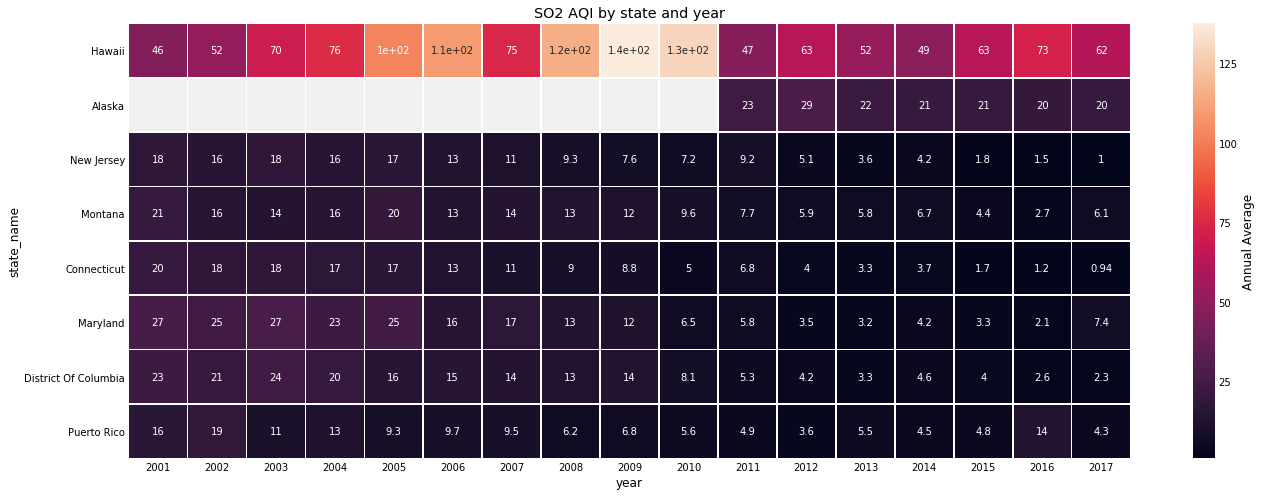

In [37]:
test2=df.loc[df['parameter_name']=='Sulfur dioxide'].loc[df['year']>2000]
test2 = pd.pivot_table(test2, index='state_name', values='ninety_five_percentile', columns='year')
test2 = test2.sort_values(by=[2011],ascending = False)
f, ax = plt.subplots(figsize=(20,8))
ax.set_title('SO2 AQI by state and year')
sns.heatmap(test2, annot=True, linewidths=.5, ax=ax,cbar_kws={'label': 'Annual Average'})

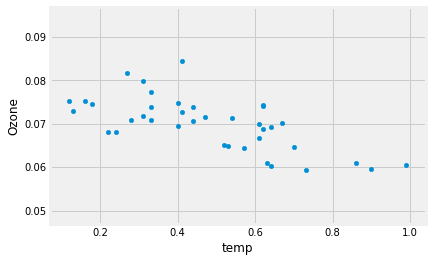

In [38]:
ninety_five.loc[:,['Ozone','temp']].plot(kind='scatter',x='temp', y='Ozone')

In [39]:
ninety_five.head()

,Average Ambient Pressure,Average Ambient Temperature,Carbon monoxide,Nitrogen dioxide (NO2),Outdoor Temperature,Ozone,Sulfur dioxide,temp
year,,,,,,,,
1980,NaN,NaN,4.473324,63.424296,60.250000,0.081761,40.147226,0.27
1981,NaN,NaN,4.320641,56.464545,73.904762,0.073771,38.913079,0.33
1982,NaN,NaN,4.040848,53.723911,75.842857,0.073012,37.411012,0.13
1983,NaN,NaN,4.069038,53.368632,71.747619,0.079772,34.829016,0.31
1984,NaN,NaN,3.910003,52.952815,78.514286,0.075206,35.965004,0.16


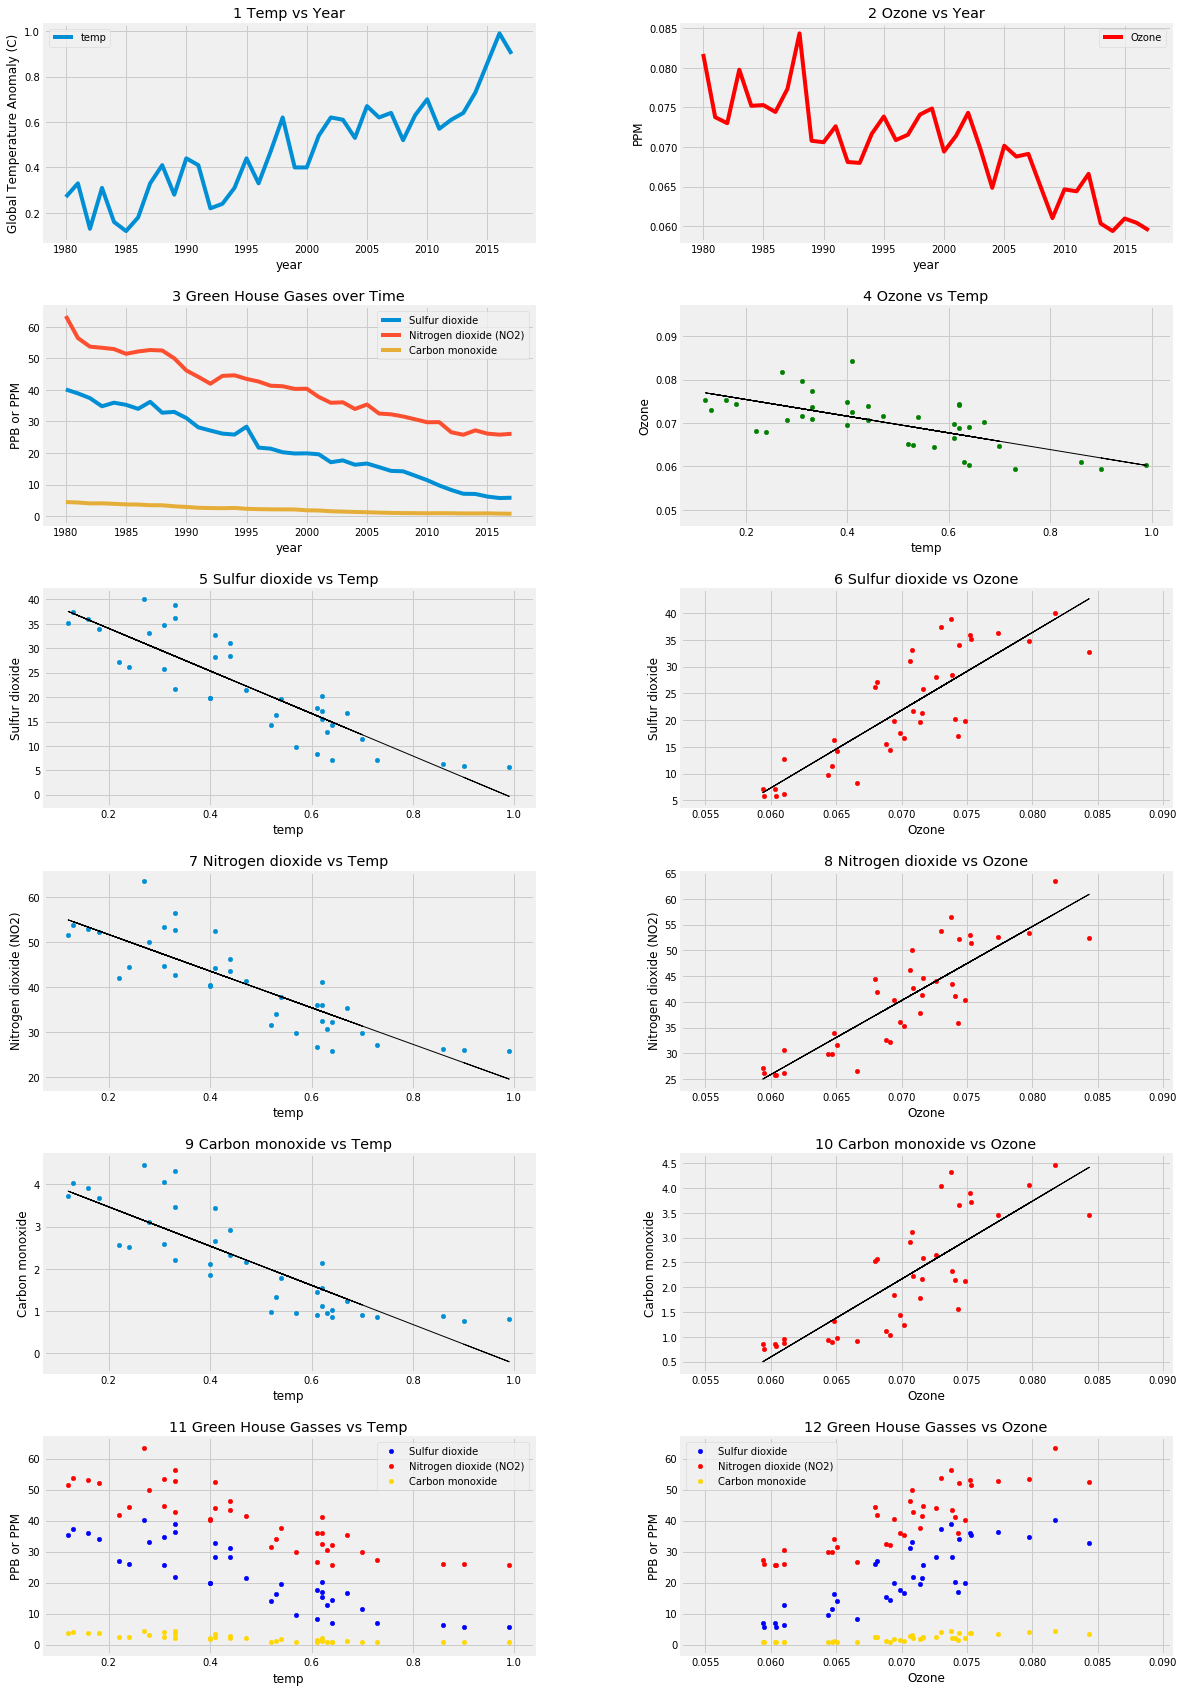

In [40]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(18,30))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

ninety_five.plot(y='temp',ax=axes[0,0])
axes[0,0].set_title('1 Temp vs Year');
axes[0,0].set_ylabel('Global Temperature Anomaly (C)')


ninety_five.plot(y='Ozone',ax=axes[0,1], color='red')
axes[0,1].set_title('2 Ozone vs Year');
axes[0,1].set_ylabel('PPM')


ninety_five.plot(kind='scatter', x='temp', y='Ozone',ax=axes[1,1], color='green')
z = np.polyfit(ninety_five['temp'], ninety_five['Ozone'], 1)
p = np.poly1d(z)
axes[1,1].plot(ninety_five['temp'],p(ninety_five['temp']), color='black',linestyle="-",linewidth=1)
axes[1,1].set_title('4 Ozone vs Temp');

ninety_five.plot(y='Sulfur dioxide',ax=axes[1,0])
ninety_five.plot(y='Nitrogen dioxide (NO2)',ax=axes[1,0])
ninety_five.plot(y='Carbon monoxide',ax=axes[1,0])
axes[1,0].set_title('3 Green House Gases over Time');
axes[1,0].set_ylabel('PPB or PPM')


ninety_five.plot(kind='scatter', x='temp', y='Sulfur dioxide',ax=axes[2,0])
z = np.polyfit(ninety_five['temp'], ninety_five['Sulfur dioxide'], 1)
p = np.poly1d(z)
axes[2,0].plot(ninety_five['temp'],p(ninety_five['temp']), color='black',linestyle="-",linewidth=1)
axes[2,0].set_title('5 Sulfur dioxide vs Temp');


ninety_five.plot(kind='scatter', x='temp', y='Nitrogen dioxide (NO2)',ax=axes[3,0])
z = np.polyfit(ninety_five['temp'], ninety_five['Nitrogen dioxide (NO2)'], 1)
p = np.poly1d(z)
axes[3,0].plot(ninety_five['temp'],p(ninety_five['temp']), color='black',linestyle="-",linewidth=1)
axes[3,0].set_title('7 Nitrogen dioxide vs Temp');


ninety_five.plot(kind='scatter', x='temp', y='Carbon monoxide',ax=axes[4,0])
z = np.polyfit(ninety_five['temp'], ninety_five['Carbon monoxide'], 1)
p = np.poly1d(z)
axes[4,0].plot(ninety_five['temp'],p(ninety_five['temp']), color='black',linestyle="-",linewidth=1)
axes[4,0].set_title('9 Carbon monoxide vs Temp');


ninety_five.plot(kind='scatter', x='Ozone', y='Sulfur dioxide',ax=axes[2,1],color='red')
z = np.polyfit(ninety_five['Ozone'], ninety_five['Sulfur dioxide'], 1)
p = np.poly1d(z)
axes[2,1].plot(ninety_five['Ozone'],p(ninety_five['Ozone']), color='black',linestyle="-",linewidth=1)
axes[2,1].set_title('6 Sulfur dioxide vs Ozone');


ninety_five.plot(kind='scatter', x='Ozone', y='Nitrogen dioxide (NO2)',ax=axes[3,1],color='red')
z = np.polyfit(ninety_five['Ozone'], ninety_five['Nitrogen dioxide (NO2)'], 1)
p = np.poly1d(z)
axes[3,1].plot(ninety_five['Ozone'],p(ninety_five['Ozone']), color='black',linestyle="-",linewidth=1)
axes[3,1].set_title('8 Nitrogen dioxide vs Ozone');


ninety_five.plot(kind='scatter', x='Ozone', y='Carbon monoxide',ax=axes[4,1],color='red')
z = np.polyfit(ninety_five['Ozone'], ninety_five['Carbon monoxide'], 1)
p = np.poly1d(z)
axes[4,1].plot(ninety_five['Ozone'],p(ninety_five['Ozone']), color='black',linestyle="-",linewidth=1)
axes[4,1].set_title('10 Carbon monoxide vs Ozone');


ninety_five.plot(kind='scatter', x='temp', y='Sulfur dioxide',ax=axes[5,0], color='blue', label='Sulfur dioxide')
ninety_five.plot(kind='scatter', x='temp', y='Nitrogen dioxide (NO2)',ax=axes[5,0], color = 'red', label='Nitrogen dioxide (NO2)')
ninety_five.plot(kind='scatter', x='temp', y='Carbon monoxide',ax=axes[5,0], color='gold', label='Carbon monoxide')
axes[5,0].set_title('11 Green House Gasses vs Temp');
axes[5,0].set_ylabel('PPB or PPM')
axes[5,0].legend()

ninety_five.plot(kind='scatter', x='Ozone', y='Sulfur dioxide',ax=axes[5,1], color='blue', label='Sulfur dioxide')
ninety_five.plot(kind='scatter', x='Ozone', y='Nitrogen dioxide (NO2)',ax=axes[5,1], color = 'red', label='Nitrogen dioxide (NO2)')
ninety_five.plot(kind='scatter', x='Ozone', y='Carbon monoxide',ax=axes[5,1], color='gold', label='Carbon monoxide')
axes[5,1].set_title('12 Green House Gasses vs Ozone');
axes[5,1].set_ylabel('PPB or PPM')
axes[5,1].legend()



plt.show()

In [41]:
ninety_five.head()

,Average Ambient Pressure,Average Ambient Temperature,Carbon monoxide,Nitrogen dioxide (NO2),Outdoor Temperature,Ozone,Sulfur dioxide,temp
year,,,,,,,,
1980,NaN,NaN,4.473324,63.424296,60.250000,0.081761,40.147226,0.27
1981,NaN,NaN,4.320641,56.464545,73.904762,0.073771,38.913079,0.33
1982,NaN,NaN,4.040848,53.723911,75.842857,0.073012,37.411012,0.13
1983,NaN,NaN,4.069038,53.368632,71.747619,0.079772,34.829016,0.31
1984,NaN,NaN,3.910003,52.952815,78.514286,0.075206,35.965004,0.16


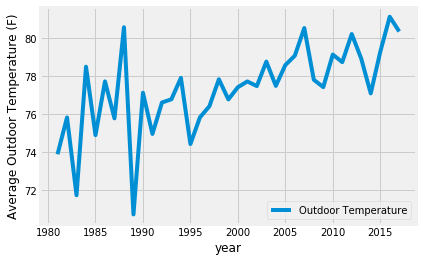

In [42]:
ninety_five.iloc[1:,:].plot(y='Outdoor Temperature')
plt.ylabel('Average Outdoor Temperature (F)')

plt.show()